# Cartoonizing an Image

In order to achieve the cartoon filter effect, we need a bilateral filter and edge detection. The bilateral filter will reduce the color palette in the image mimiking a cartoon drawing. Then we can apply edge detection to the resulting image to generate bold silhouettes.

In doing this, there are five basic steps upon reach a threshold is reached

1. Apply a **bilateral filter** to reduce the color palette of the image.
2. Convert the original color image into **grayscale**.
3. Apply a **median blur** to reduce image noise.
4. Use **adaptive thresholding** to detect and emphasize the edges in an edge mask.
5. Combine the color image from step 1 with the edge mask from step 4.

In [0]:
#import libraries 
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define a colospace function to read your image

In order to set multiple colorspaces for outputing an image, a function will be set. This allows you print an image directly as an RBG, HSV or Grayscale image and can be run directly after importing the libraries 

In [0]:
img_dir = '/tmp/images/josh.jpg'  #this accepts the filepath

def rgb_img(img_dir):
    #reads from a BGR image file to a RGB
    img = cv2.imread(img_dir)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def hsv_img(img_dir):
    #reads from a RGB image file to a HSV array
    hsv = cv2.imread(img_dir)
    return cv2.cvtColor(hsv, cv2.COLOR_RGB2HSV)

def img_read(img_dir):
    #reads from a RGB image file to grayscale image array
    rgb = rgb_img(img_dir)
    hsv = hsv_img(img_dir)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return rgb, hsv, gray

In [0]:
#define your function 
josh_rgb, josh_hsv, josh_gray = img_read(img_dir)

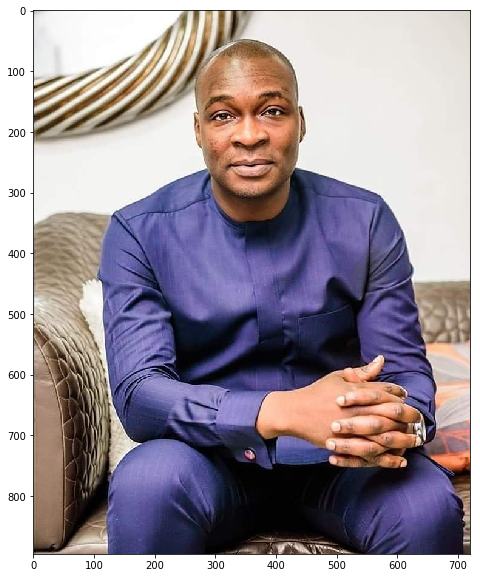

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(josh_rgb)

# Using a bilateral filter to reduce color palette

Using a strong bilateral filter for a RGB image is suitable in converting the image into a cartoon, because it smoothens flat regions while keeping edges sharp.

The first approach in reducing the computational cost is to perform the bilateral filtering on an image of low resolution. In order to scale an RGB image (`imgRGB`) to a quarter of its size, we use the `cv2.resize`:

In [0]:
#scaling the image to quater of its actual size
img_scale = cv2.resize(josh_rgb, (0,0), fx=0.5, fy=0.5)
img_scale = cv2.pyrDown(josh_rgb)

However, at this scale, the bilateral filter might still be too slow to run in real time. Another protocol is to repeatedly (say, five times) apply a small bilateral filter to the image:

The three arguments in `cv2.bilateralFilter` regulates the diameter of the pixel boundaries (`d`) and the standard deviation of the filter in the color space (`sigmaColor`) and coordinate space (`sigmaSpace`).

In [0]:
num_iter = 5
for _ in range(num_iter):
    img_scale = cv2.bilateralFilter(img_scale, d=9, sigmaColor=9, sigmaSpace=7)

In [0]:
#restoring the image
josh_blur = cv2.pyrUp(img_scale)

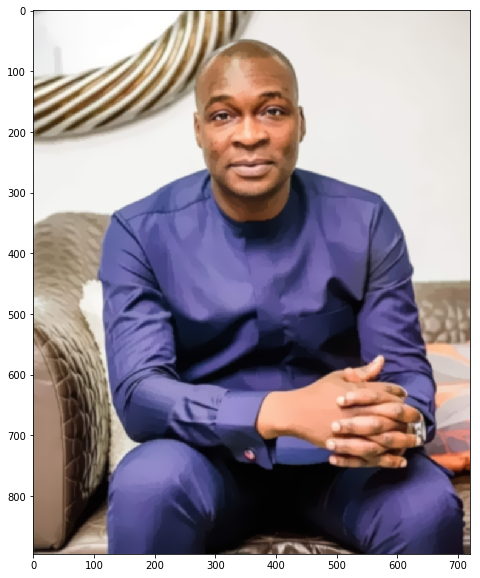

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(josh_blur)

# Detecting edges in the image

Using the `cv2.adaptiveThreshold`, this function uses a threshold pixel value to convert a grayscale image into a binary image. That is, if a pixel value in the original image is above the threshold given, then the pixel value in the final image will be 255. Otherwise, it will be 0. 

We first convert the RGB image (`josh_rgb`) to grayscale (`img_gray`) and then apply a median blur with a seven-pixel local neighborhood:

In [0]:
# convert to grayscale and apply median blur
img_gray = cv2.cvtColor(josh_rgb, cv2.COLOR_RGB2GRAY)
img_blur = cv2.medianBlur(img_gray, 7)

After reducing the noise, we can detect and enhance the edges using adaptive thresholding. With `cv2.ADAPTIVE_THRESH_MEAN_C` algorithm with `blockSize=9` will ensure that the threshold is applied to the mean of a 9 x 9 neighborhood minus `C=2`:

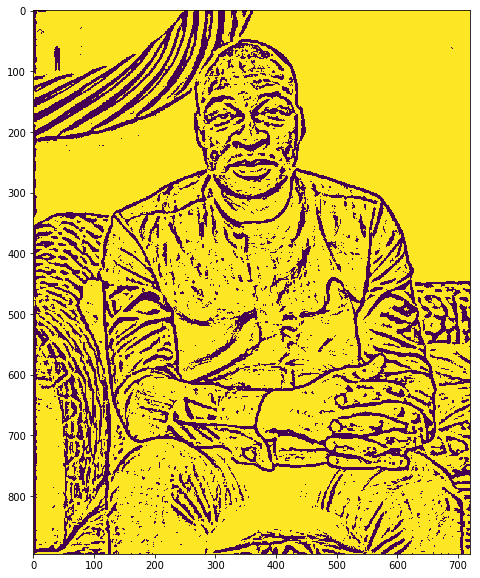

In [0]:
img_edge = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
plt.figure(figsize=(10,10))
plt.imshow(img_edge)

# Combining colors and outlines to produce a cartoon effect

The last step is to fuse the two effects together into a single image using `cv2.bitwise_and` to perform the magic 

In [0]:
def cartoon_filter(self, josh_rgb):
    numDownSamples = 2 # number of downscaling steps
    numBilateralFilters = 7  # number of bilateral filtering steps

    #first step
    # downsample image using Gaussian pyramid
    img_color = josh_rgb
    for _ in range(numDownSamples):
        img_color = cv2.pyrDown(img_color)

    # repeatedly apply small bilateral filter instead of applying
    # one large filter
    for _ in range(numBilateralFilters):
        img_color = cv2.bilateralFilter(img_color, 9, 9, 7)

    # upsample image to original size
    for _ in range(numDownSamples):
        img_color = cv2.pyrUp(img_color)

    #combine steps steps 2 & 3
    # convert to grayscale and apply median blur
    img_gray = cv2.cvtColor(josh_rgb, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.medianBlur(img_gray, 7)

    #fourth step
    # detect and enhance edges
    img_edge = cv2.adaptiveThreshold(img_blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)

    #fifth step
    # convert back to color so that it can be bit-AND
    # with color image
    img_edge = cv2.cvtColor(img_edge, cv2.COLOR_GRAY2RGB)
    return cv2.bitwise_and(img_color, img_edge)

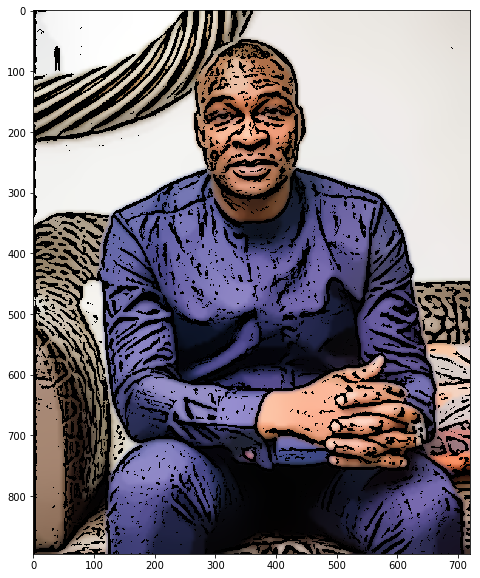

In [0]:
josh = cartoon_filter(img_edge, josh_rgb)
plt.figure(figsize=(10,10))
plt.imshow(josh)